In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/im2latex_finetuned/pytorch/default/1/trocr-large-rendered-im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/input/im2latex_finetuned/pytorch/default/1/trocr-large-rendered-im2latex")
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl
# from data.datasets import set_seed

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "/kaggle/input/dataset-sentences/img_data2/img_data2", 
                 csv_file = "labels_mathematical.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        self.labels = pd.read_csv(self.csv_path, usecols=['label', 'col'])
        
        # Remove '.png' from filenames in the 'col' column
        #self.labels['col'] = self.labels['col'].str.replace('.png', '', regex=False)
        
        # Split data into training and validation sets
#         self.labels, self.labels_val = train_test_split(self.labels, test_size=test_split, random_state=random_seed)

        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train":
            img_name = os.path.join(self.img_dir, self.labels.iloc[idx]["col"])  # Use "col" for filenames
        else:
            img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx]["col"])  # Use "col" for filenames

        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(images=image, padding="max_length", return_tensors="pt").to(self.device)
        
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze()  # Remove batch dimension

        if self.partition == "train":
            caption = self.labels.iloc[idx]["label"]  # Use "label" for captions
        else:
            caption = self.labels_val.iloc[idx]["label"]  # Use "label" for captions
        
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding="max_length", max_length=256,
        ).to(self.device).squeeze()

        return inputs, caption

        
def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
BATCH_SIZE = 1 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
assert (train_ds.labels_val.values == val_ds.labels_val.values).all()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [2]:
# Install jiwer for CER calculation
!pip install jiwer

# Import jiwer for CER calculation
from jiwer import cer

# ... your code remains unchanged until the training loop ...

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.6 MB/s eta 0:00:00a 0:00:01


In [3]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled=True)

# Training and validation loop with CER calculation
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]

            optimizer.zero_grad()
            with t.autocast(device_type="cuda", dtype=t.float16, enabled=True):
                outputs = model(pixel_values=pixel_values, labels=captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    # Validation phase
    model.eval()
    with t.no_grad():
        val_losses = []
        cer_scores = []  # To store CER for each validation sample

        for batch, captions in tqdm(val_dl, desc="Validation"):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values=pixel_values, labels=captions)
            val_losses.append(outputs.loss.item())

            # Generate predictions and calculate CER
            generated_tokens = model.generate(pixel_values, max_new_tokens=256)
            predictions = processor.batch_decode(generated_tokens, skip_special_tokens=True)

            # Calculate CER for each prediction vs ground truth
            for pred, true_caption in zip(predictions, captions):
                true_caption = processor.decode(true_caption, skip_special_tokens=True)
                cer_score = cer(true_caption, pred)
                cer_scores.append(cer_score)
        
        avg_val_loss = np.mean(val_losses)
        avg_cer = np.mean(cer_scores)
        print(f"Validation Loss: {avg_val_loss}, CER: {avg_cer}")

        val_history.append(avg_val_loss)
        val_timesteps.append(len(history) - 1)
        model.train()  # Switch back to training mode after validation

# Save model and processor
model.save_pretrained("/kaggle/working/model2/model/trocr_model_im2latex")
processor.save_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

/tmp/ipykernel_30/1395136962.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = t.cuda.amp.GradScaler(enabled=True)
Epoch 1/5:   0%|          | 0/504 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Validation: 100%|██████████| 126/126 [01:31<00:00,  1.38it/s]


Validation Loss: 0.027871837628481444, CER: 0.09053856880196566


Validation: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s]


Validation Loss: 0.0051535584987158515, CER: 0.021808309023658462


Validation: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Validation Loss: 0.0060371558107103086, CER: 0.14189717968402152


Validation: 100%|██████████| 126/126 [01:40<00:00,  1.25it/s]


Validation Loss: 0.01462493875234421, CER: 0.09571533402213371


Validation: 100%|██████████| 126/126 [01:41<00:00,  1.24it/s]


Validation Loss: 0.004857726642483844, CER: 0.0768758854392751


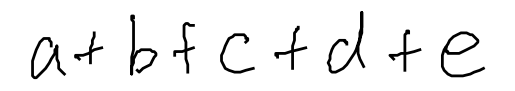

Prediction:
a + b + c + d + e


<IPython.core.display.Math object>

CER for this sample: 0.0000
Ground Truth:
a + b + c + d + e


<IPython.core.display.Math object>

In [3]:
# Load model for testing
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/model2/model/trocr_model_im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("/kaggle/working/model2/model/trocr_processor_im2latex")

# Display a random validation result with CER
import random
model.eval()

idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math

display(image)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens=256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))

# Calculate CER for this specific sample
cer_value = cer(caption, pred)
print(f"CER for this sample: {cer_value:.4f}")

print("Ground Truth:")
print(caption)
display(Math(caption))

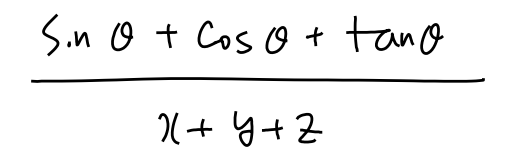

Prediction:
\frac{\sin \theta + \cos \theta + \tan \theta}{x + y + z}


<IPython.core.display.Math object>

CER for this sample: 0.0000
Ground Truth:
\frac{\sin \theta + \cos \theta + \tan \theta}{x + y + z}


<IPython.core.display.Math object>

In [24]:
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math

display(image)

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens=256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))

# Calculate CER for this specific sample
cer_value = cer(caption, pred)
print(f"CER for this sample: {cer_value:.4f}")

print("Ground Truth:")
print(caption)
display(Math(caption))